# DELTA ANALYISIS - Storage Output and Flow from HEC-HMS

**stor_upper** = storage in upper reservoir (m³)

**stor_lower** = storage in lower reservoir (m³)

**reservoir_storage** = ([stor_upper] + [stor_lower])/2 (m³) After first 5 years


# Install Libraries

In [150]:
import numpy as np
import pandas as pd
from dateutil import parser
from pandas.errors import OutOfBoundsDatetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations
import math
from matplotlib.dates import MonthLocator, DateFormatter
import requests
from io import StringIO
import os
import matplotlib.dates as mdates

# Hard Coded Variables

## Observed

In [94]:
observed_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed/penman'
observed_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed/flow'

## S1

In [95]:
s1_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1/penman'
s1_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1/flow'

## S2

In [96]:
s2_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2/penman'
s2_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2/flow'

## S3

In [97]:
s3_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3/penman'
s3_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3/flow'

## S4

In [98]:
s4_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4/penman'
s4_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4/flow'

# Utility Functions

In [99]:
def read_csv_files_in_folder(folder_path):
    dataframes = []
    
    files = sorted(os.listdir(folder_path))  # Sort files alphabetically
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    return dataframes


In [100]:
def standardize_date(date_str):
    """
    Convert a date string to the standardized ISO format (YYYY-MM-DD).

    This function is standardize date representations  when dealing with datasets that have dates in 
    inconsistent formats like the output from HEC HMS.

    Parameters:
    - date_str (str): The date string to standardize.

    Returns:
    - str: A date string in the ISO format (YYYY-MM-DD) if successful, or pd.NaT if parsing fails.
    """
    try:
        # Attempt to parse the date using the more flexible dateutil parser
        return parser.parse(date_str).strftime('%Y-%m-%d')
    except (parser.ParserError, TypeError, ValueError):
        # If there's an error during parsing, return NaT
        return pd.NaT

def standardize_dates_in_dataframes(dfs, date_column_name='Date'):
    """
    Apply date standardization to a specific column across a list of pandas DataFrames.

    Each DataFrame in the list is processed to standardize the date format of the specified 
    column to the ISO format (YYYY-MM-DD) using the `standardize_date` function.

    Parameters:
    - dfs (list of pd.DataFrame): The list of DataFrames to process.
    - date_column_name (str): The name of the column containing date strings to standardize.

    Returns:
    - list of pd.DataFrame: A list of DataFrames with the date column standardized.
    """
    standardized_dfs = []
    for df in dfs:
        df[date_column_name] = df[date_column_name].apply(lambda x: standardize_date(str(x)))
        standardized_dfs.append(df)
    return standardized_dfs

In [107]:
def merge_dataframes(df_t_p_list, df_f_list):
    """
    Merge two lists of DataFrames based on the 'Date' column, standardize 'date' column names to 'Date',
    and calculate the reservoir_storage as the mean of stor_upper and stor_lower.
    The resulting DataFrames are sorted by 'Date' and exclude the first five years.

    Parameters:
    - df_t_p_list: List of temperature and precipitation DataFrames with a standardized 'Date' column.
    - df_f_list: List of flow DataFrames with 'stor_upper', 'stor_lower', and a standardized 'Date' column.

    Returns:
    - merged_dfs: List of merged DataFrames with 'reservoir_storage' calculated, specified columns dropped, 
                  first five years excluded, and entries sorted by 'Date'.
    
    Raises:
    - ValueError: If the input lists are not of the same length.
    """
    # Check if the lists of DataFrames are the same size
    if len(df_t_p_list) != len(df_f_list):
        raise ValueError("The lists of DataFrames must be the same length.")

    merged_dfs = []
    columns_to_drop = [
        'time', 'q_in_upper', 'elev_upper', 'q_out_upper',
        'q_in_lower', 'elev_lower', 'q_out_lower'
    ]
    
    for df_t_p, df_f in zip(df_t_p_list, df_f_list):
        # Standardize column names by removing spaces and renaming date columns
        df_f.columns = df_f.columns.str.replace(' ', '')
        df_f.rename(columns={'date': 'Date'}, inplace=True)
        
        # Ensure 'Date' is in datetime format
        df_f['Date'] = pd.to_datetime(df_f['Date'])
        df_t_p['Date'] = pd.to_datetime(df_t_p['Date'])

        # Merge the two dataframes on 'Date'
        merged_df = pd.merge(df_t_p, df_f, on='Date', how='inner')

        # Drop specified columns
        merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], errors='ignore', inplace=True)
        
        # Ensure 'Date' is in datetime format for merged_df
        merged_df['Date'] = pd.to_datetime(merged_df['Date'])

        # Exclude the first five years from the data
        first_year = merged_df['Date'].dt.year.min()
        cutoff_year = first_year + 5
        merged_df = merged_df[merged_df['Date'].dt.year >= cutoff_year]

        # Calculate the reservoir_storage as the mean of stor_upper and stor_lower
        if 'stor_upper' in merged_df.columns and 'stor_lower' in merged_df.columns:
            merged_df['reservoir_storage'] = (merged_df['stor_upper'] + merged_df['stor_lower']) / 2

        # Sort by 'Date'
        merged_df.sort_values(by='Date', inplace=True)

        merged_dfs.append(merged_df)

    return merged_dfs


In [218]:
def plot_monthly_average_with_range(df_list, title_prefix=""):
    """
    Create a plot for the monthly average with range of reservoir storage across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and 'reservoir_storage' columns.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month and year information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Group by month and calculate the average, minimum, and maximum of reservoir storage
    monthly_agg_data = combined_df.groupby('Month')['reservoir_storage'].agg(['mean', 'min', 'max'])

    # Plot the monthly average, minimum, and maximum over all dataframes
    plt.figure(figsize=(15, 8))
    plt.plot(monthly_agg_data.index, monthly_agg_data['mean'], marker='o', linestyle='-', color='b', label='Average')
    plt.fill_between(
        monthly_agg_data.index,
        monthly_agg_data['min'],
        monthly_agg_data['max'],
        color='b',
        alpha=0.2,
        label='Range'
    )

    plt.xlabel('Month')
    plt.ylabel('Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Monthly Average with Range (Reservoir Storage) Over All Realizations')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.locator_params(axis='y', nbins=10)  

    plt.grid(True, linestyle='--', alpha=0.7, which='major', axis='both')  
    plt.legend()
    plt.tight_layout()
    plt.show()


In [219]:
def plot_timeseries_with_range(df_list, title_prefix=""):
    """
    Create a time series plot for reservoir storage with shading representing the range (min and max)
    across all DataFrames, with simplified y-axis gridlines.

    Parameters:
    - df_list: List of DataFrames with 'Date' and 'reservoir_storage' columns.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime if not already
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Sort by 'Date'
    combined_df.sort_values(by='Date', inplace=True)

    # Calculate daily min, max, and mean for plotting
    daily_stats = combined_df.groupby('Date')['reservoir_storage'].agg(['min', 'max', 'mean'])

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.plot(daily_stats.index, daily_stats['mean'], label='Daily Mean', color='b')
    plt.fill_between(daily_stats.index, daily_stats['min'], daily_stats['max'], color='b', alpha=0.1, label='Range (Min-Max)')

    plt.xlabel('Date')
    plt.ylabel('Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Time Series of Reservoir Storage with Range')

    # Setting up the x-axis to display every two years and rotate labels for better readability
    ax = plt.gca()  # Get current axes
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Simplifying y-axis gridlines
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of major gridlines on y-axis
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Show only major gridlines
    plt.minorticks_off()  # Disable minor ticks

    plt.legend()
    plt.tight_layout()
    plt.show()


In [220]:
def plot_timeseries_with_range_from_year(df_list, start_year, title_prefix=""):
    """
    Create a time series plot for reservoir storage with shading representing the range (min and max)
    across all DataFrames, starting from a specified year. If the title_prefix is 'Historical', 
    'range' is omitted from the title and legend.

    Parameters:
    - df_list: List of DataFrames with 'Date' and 'reservoir_storage' columns.
    - start_year: Integer specifying the start year for the plot.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime if not already
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Filter data to start from the specified year
    combined_df = combined_df[combined_df['Date'].dt.year >= start_year]

    # Sort by 'Date'
    combined_df.sort_values(by='Date', inplace=True)

    # Calculate daily min, max, and mean for plotting
    daily_stats = combined_df.groupby('Date')['reservoir_storage'].agg(['min', 'max', 'mean'])

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.plot(daily_stats.index, daily_stats['mean'], label='Daily Mean', color='b')
    fill_label = 'Range (Min-Max)' if title_prefix != "Historical" else None
    plt.fill_between(daily_stats.index, daily_stats['min'], daily_stats['max'], color='b', alpha=0.1, label=fill_label)

    plt.xlabel('Date')
    plt.ylabel('Reservoir Storage (m³)')
    title = f'{title_prefix} Time Series of Reservoir Storage' + ("" if title_prefix == "Historical" else " with Range") + f' from {start_year}'
    plt.title(title)

    # Setting up the x-axis to display every two years and rotate labels for better readability
    ax = plt.gca()  # Get current axes
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Simplifying y-axis gridlines
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of major gridlines on y-axis
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Show only major gridlines
    plt.minorticks_off()  # Disable minor ticks

    # Conditionally add legend based on title_prefix
    if title_prefix != "Historical":
        plt.legend()
    plt.tight_layout()
    plt.show()


In [243]:
def plot_average_timeseries_for_lists(list_of_lists_of_dfs, labels, colorindex=[], title_prefix=""):
    """
    Plot the average of the reservoir_storage values as a time series for each list of DataFrames with custom labels,
    showing ticks for every two years on the x-axis at an angle and reducing y-axis gridlines for better readability.

    Parameters:
    - list_of_lists_of_dfs: List of lists of DataFrames with 'Date' and 'reservoir_storage' columns.
    - labels: List of strings for legend labels, corresponding to each list of DataFrames.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=(15, 8))
    
    # Check if the number of labels matches the number of lists
    if len(labels) != len(list_of_lists_of_dfs):
        raise ValueError("Number of labels must match the number of lists of DataFrames.")
    
    # Create a color palette
    cmap= plt.colormaps['Accent']
    colors = [cmap.colors[i] for i in colorindex]

    for idx, df_list in enumerate(list_of_lists_of_dfs):
        # Combine all dataframes in the current list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Convert 'Date' column to datetime if not already
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])

        # Sort by 'Date'
        combined_df.sort_values(by='Date', inplace=True)

        # Calculate daily mean for plotting
        daily_mean = combined_df.groupby('Date')['reservoir_storage'].mean()

        # Plotting
        plt.plot(daily_mean.index, daily_mean, label=labels[idx], color=colors[idx])

    # Setting up the x-axis to display every two years and rotate labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Simplifying y-axis gridlines
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of major gridlines on y-axis

    plt.xlabel('Date')
    plt.ylabel('Average Reservoir Storage (m³)')
    plt.title(f'Average Reservoir Storage Time Series Across All Realizations')

    # Grid configuration
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)  # Show only major gridlines
    plt.minorticks_off()  # Disable minor ticks

    plt.legend(title="Scenarios")
    plt.tight_layout()
    plt.show()


In [244]:
def plot_average_timeseries_for_lists_with_diff_start_years(list_of_lists_of_dfs, labels, start_year_first, start_year_others, colorindex=[], title_prefix=""):
    """
    Plot the average of the reservoir_storage values as a time series for each list of DataFrames with custom labels,
    applying a different start year for the first list of DataFrames and a common start year for the rest of the lists.
    Shows ticks for every two years on the x-axis at an angle and reduces y-axis gridlines for better readability.

    Parameters:
    - list_of_lists_of_dfs: List of lists of DataFrames with 'Date' and 'reservoir_storage' columns.
    - labels: List of strings for legend labels, corresponding to each list of DataFrames.
    - start_year_first: Integer specifying the start year for the first list of DataFrames.
    - start_year_others: Integer specifying the common start year for the rest of the lists of DataFrames.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=(15, 8))
    
    # Check if the number of labels matches the number of lists
    if len(labels) != len(list_of_lists_of_dfs):
        raise ValueError("Number of labels must match the number of lists of DataFrames.")
    
    # Create a color palette
    cmap= plt.colormaps['Accent']
    colors = [cmap.colors[i] for i in colorindex]
    
    for idx, df_list in enumerate(list_of_lists_of_dfs):
        # Combine all dataframes in the current list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Convert 'Date' column to datetime if not already
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        
        # Apply different start years based on the index
        if idx == 0:
            combined_df = combined_df[combined_df['Date'].dt.year >= start_year_first]
        else:
            combined_df = combined_df[combined_df['Date'].dt.year >= start_year_others]

        # Sort by 'Date'
        combined_df.sort_values(by='Date', inplace=True)

        # Calculate daily mean for plotting
        daily_mean = combined_df.groupby('Date')['reservoir_storage'].mean()

        # Plotting
        plt.plot(daily_mean.index, daily_mean, label=labels[idx], color=colors[idx])

    # Setting up the x-axis to display every two years and rotate labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Simplifying y-axis gridlines
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.xlabel('Date')
    plt.ylabel('Average Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Average Reservoir Storage Time Series Over All Realizations')

    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.minorticks_off()

    plt.legend(title="Scenarios")
    plt.tight_layout()
    plt.show()


In [245]:
def plot_monthly_average_for_lists_with_diff_start_years(list_of_lists_of_dfs, labels, start_year_first, start_year_others, colorindex=[], title_prefix=""):
    """
    Plot the monthly average of the reservoir_storage values over all years for each list of DataFrames with custom labels,
    applying a different start year for the first list of DataFrames and a common start year for the rest of the lists.
    Each list is represented as a separate line on the plot with 12 points for each month.

    Parameters:
    - list_of_lists_of_dfs: List of lists of DataFrames with 'Date' and 'reservoir_storage' columns.
    - labels: List of strings for legend labels, corresponding to each list of DataFrames.
    - start_year_first: Integer specifying the start year for the first list of DataFrames.
    - start_year_others: Integer specifying the common start year for the rest of the lists of DataFrames.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=(15, 8))
    
    # Check if the number of labels matches the number of lists
    if len(labels) != len(list_of_lists_of_dfs):
        raise ValueError("Number of labels must match the number of lists of DataFrames.")
    
    # Create a color palette
    cmap= plt.colormaps['Accent']
    colors = [cmap.colors[i] for i in colorindex]
    
    for idx, df_list in enumerate(list_of_lists_of_dfs):
        # Combine all dataframes in the current list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Convert 'Date' column to datetime if not already and filter by start_year
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        start_year = start_year_first if idx == 0 else start_year_others
        combined_df = combined_df[combined_df['Date'].dt.year >= start_year]

        # Extract month and year information
        combined_df['Month'] = combined_df['Date'].dt.month

        # Group by month and calculate the average of reservoir_storage for each month over all years
        monthly_avg = combined_df.groupby('Month')['reservoir_storage'].mean()

        # Plotting
        plt.plot(range(1, 13), monthly_avg, label=labels[idx], color=colors[idx], marker='o')

    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.xlabel('Month')
    plt.ylabel('Average Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Monthly Average Reservoir Storage Over All Realizations')

    plt.legend(title="Scenarios")
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [246]:
def plot_average_timeseries_for_all_lists_starting_same_year(list_of_lists_of_dfs, labels, start_year, colorindex=[], title_prefix=""):
    """
    Plot the average of the reservoir_storage values as a time series for each list of DataFrames with custom labels,
    starting all lists from the same specified year. Shows ticks for every two years on the x-axis at an angle and reduces 
    y-axis gridlines for better readability.

    Parameters:
    - list_of_lists_of_dfs: List of lists of DataFrames with 'Date' and 'reservoir_storage' columns.
    - labels: List of strings for legend labels, corresponding to each list of DataFrames.
    - start_year: Integer specifying the common start year for all lists of DataFrames.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=(15, 8))
    
    # Check if the number of labels matches the number of lists
    if len(labels) != len(list_of_lists_of_dfs):
        raise ValueError("Number of labels must match the number of lists of DataFrames.")
    
    # Create a color palette
    cmap= plt.colormaps['Accent']
    colors = [cmap.colors[i] for i in colorindex]
    
    for idx, df_list in enumerate(list_of_lists_of_dfs):
        # Combine all dataframes in the current list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Convert 'Date' column to datetime if not already and filter by start_year
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        combined_df = combined_df[combined_df['Date'].dt.year >= start_year]

        # Sort by 'Date'
        combined_df.sort_values(by='Date', inplace=True)

        # Calculate daily mean for plotting
        daily_mean = combined_df.groupby('Date')['reservoir_storage'].mean()

        # Plotting
        plt.plot(daily_mean.index, daily_mean, label=labels[idx], color=colors[idx])

    # Setting up the x-axis to display every two years and rotate labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Simplifying y-axis gridlines
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.xlabel('Date')
    plt.ylabel('Average Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Average Reservoir Storage Time Series from {start_year}')

    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.minorticks_off()

    plt.legend(title="Scenarios")
    plt.tight_layout()
    plt.show()


In [255]:
def plot_monthly_average_for_lists_with_diff_start_years(list_of_lists_of_dfs, labels, start_year_first, start_year_others, colorindex=[], title_prefix=""):
    """
    Plot the monthly average of the reservoir_storage values over all years for each list of DataFrames with custom labels,
    applying a different start year for the first list of DataFrames and a common start year for the rest of the lists.
    Each list is represented as a separate line on the plot with 12 points for each month.

    Parameters:
    - list_of_lists_of_dfs: List of lists of DataFrames with 'Date' and 'reservoir_storage' columns.
    - labels: List of strings for legend labels, corresponding to each list of DataFrames.
    - start_year_first: Integer specifying the start year for the first list of DataFrames.
    - start_year_others: Integer specifying the common start year for the rest of the lists of DataFrames.
    - title_prefix: String to be added to the title of the plot (default is an empty string).

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=(15, 8))
    
    # Check if the number of labels matches the number of lists
    if len(labels) != len(list_of_lists_of_dfs):
        raise ValueError("Number of labels must match the number of lists of DataFrames.")
    
    # Use the 'Accent' colormap
    cmap= plt.colormaps['Accent']
    colors = [cmap.colors[i] for i in colorindex]
    
    for idx, df_list in enumerate(list_of_lists_of_dfs):
        # Combine all dataframes in the current list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Convert 'Date' column to datetime if not already and filter by start_year
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        start_year = start_year_first if idx == 0 else start_year_others
        combined_df = combined_df[combined_df['Date'].dt.year >= start_year]

        # Extract month and year information
        combined_df['Month'] = combined_df['Date'].dt.month

        # Group by month and calculate the average of reservoir_storage for each month over all years
        monthly_avg = combined_df.groupby('Month')['reservoir_storage'].mean()

        # Plotting
        plt.plot(range(1, 13), monthly_avg, label=labels[idx], color=colors[idx], marker='o')

    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.xlabel('Month')
    plt.ylabel('Average Reservoir Storage (m³)')
    plt.title(f'{title_prefix} Monthly Average Reservoir Storage Over All Realizations')

    plt.legend(title="Scenarios")
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Data Engineering

## Observed

In [104]:
observed_t_p = read_csv_files_in_folder(observed_folder_t_p)
observed_f = read_csv_files_in_folder(observed_folder_f)

In [105]:
observed_standardized_flow = standardize_dates_in_dataframes(observed_f, date_column_name='date')

In [108]:
observed_dfs = merge_dataframes(observed_t_p, observed_standardized_flow)

## S1

In [110]:
s1_t_p = read_csv_files_in_folder(s1_folder_t_p)
s1_f = read_csv_files_in_folder(s1_folder_f)

In [111]:
s1_standardized_flow = standardize_dates_in_dataframes(s1_f, date_column_name='date')

In [112]:
s1_dfs = merge_dataframes(s1_t_p, s1_standardized_flow)

## S2

In [113]:
s2_t_p = read_csv_files_in_folder(s2_folder_t_p)
s2_f = read_csv_files_in_folder(s2_folder_f)

In [114]:
s2_standardized_flow = standardize_dates_in_dataframes(s2_f, date_column_name='date')

In [115]:
s2_dfs = merge_dataframes(s2_t_p, s2_standardized_flow)

## S3

In [116]:
s3_t_p = read_csv_files_in_folder(s3_folder_t_p)
s3_f = read_csv_files_in_folder(s3_folder_f)

In [117]:
s3_standardized_flow = standardize_dates_in_dataframes(s3_f, date_column_name='date')

In [118]:
s3_dfs = merge_dataframes(s3_t_p, s3_standardized_flow)

## S4

In [119]:
s4_t_p = read_csv_files_in_folder(s4_folder_t_p)
s4_f = read_csv_files_in_folder(s4_folder_f)

In [120]:
s4_standardized_flow = standardize_dates_in_dataframes(s4_f, date_column_name='date')

In [121]:
s4_dfs = merge_dataframes(s4_t_p, s4_standardized_flow)

# Storage Analysis

## Observed

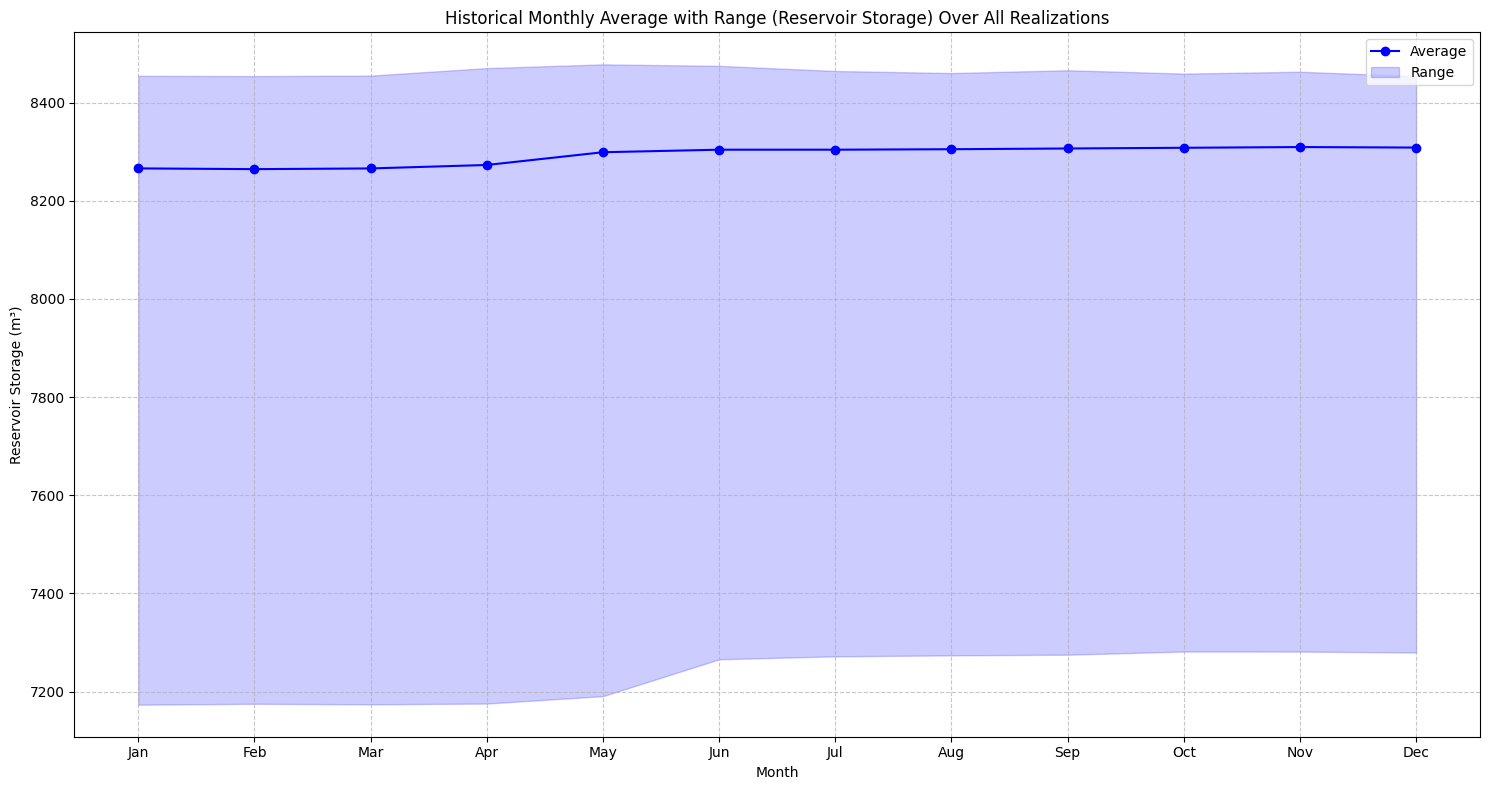

In [159]:
plot_monthly_average_with_range(observed_dfs, title_prefix="Historical")

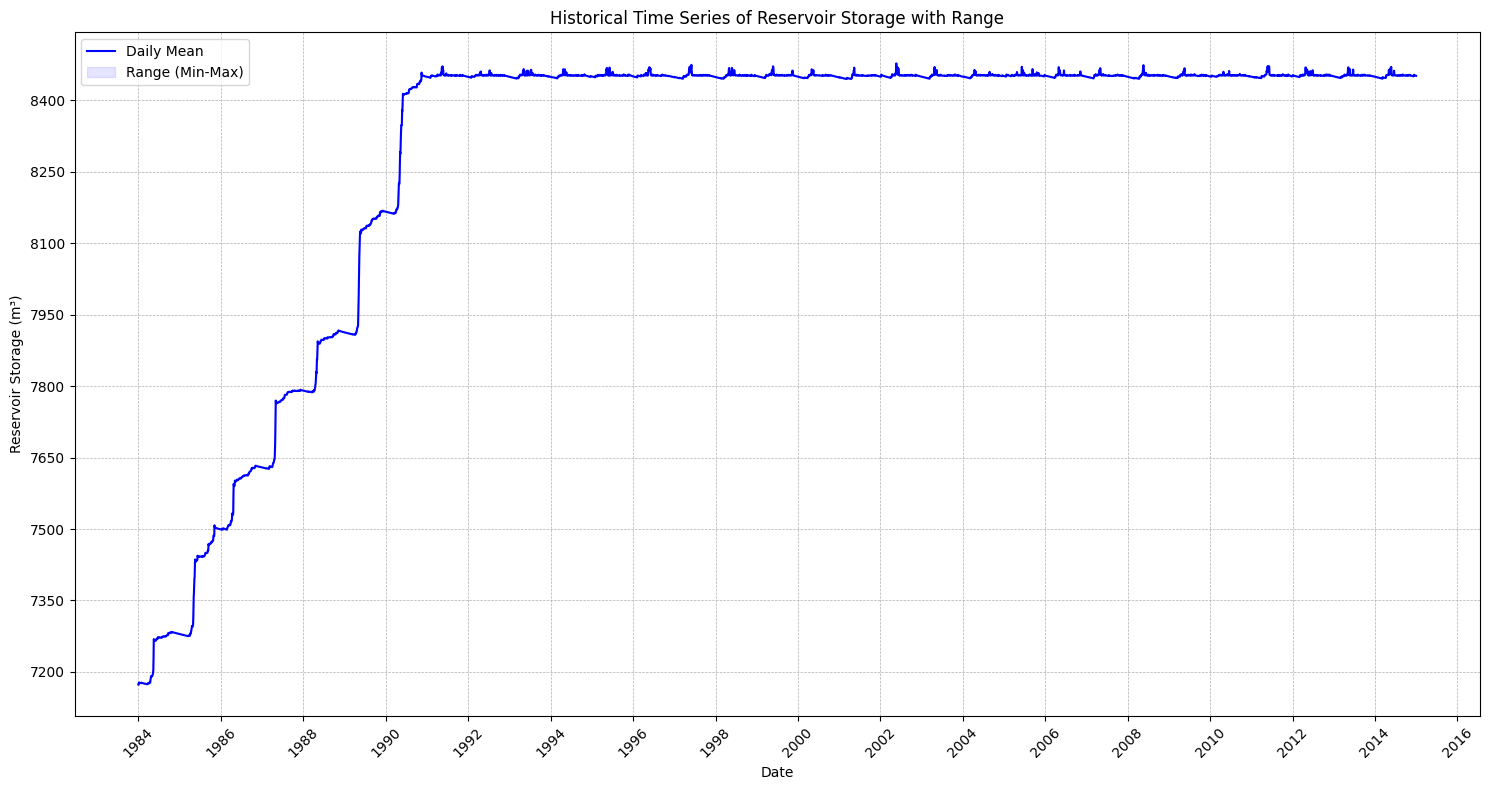

In [194]:
plot_timeseries_with_range(observed_dfs, title_prefix="Historical")

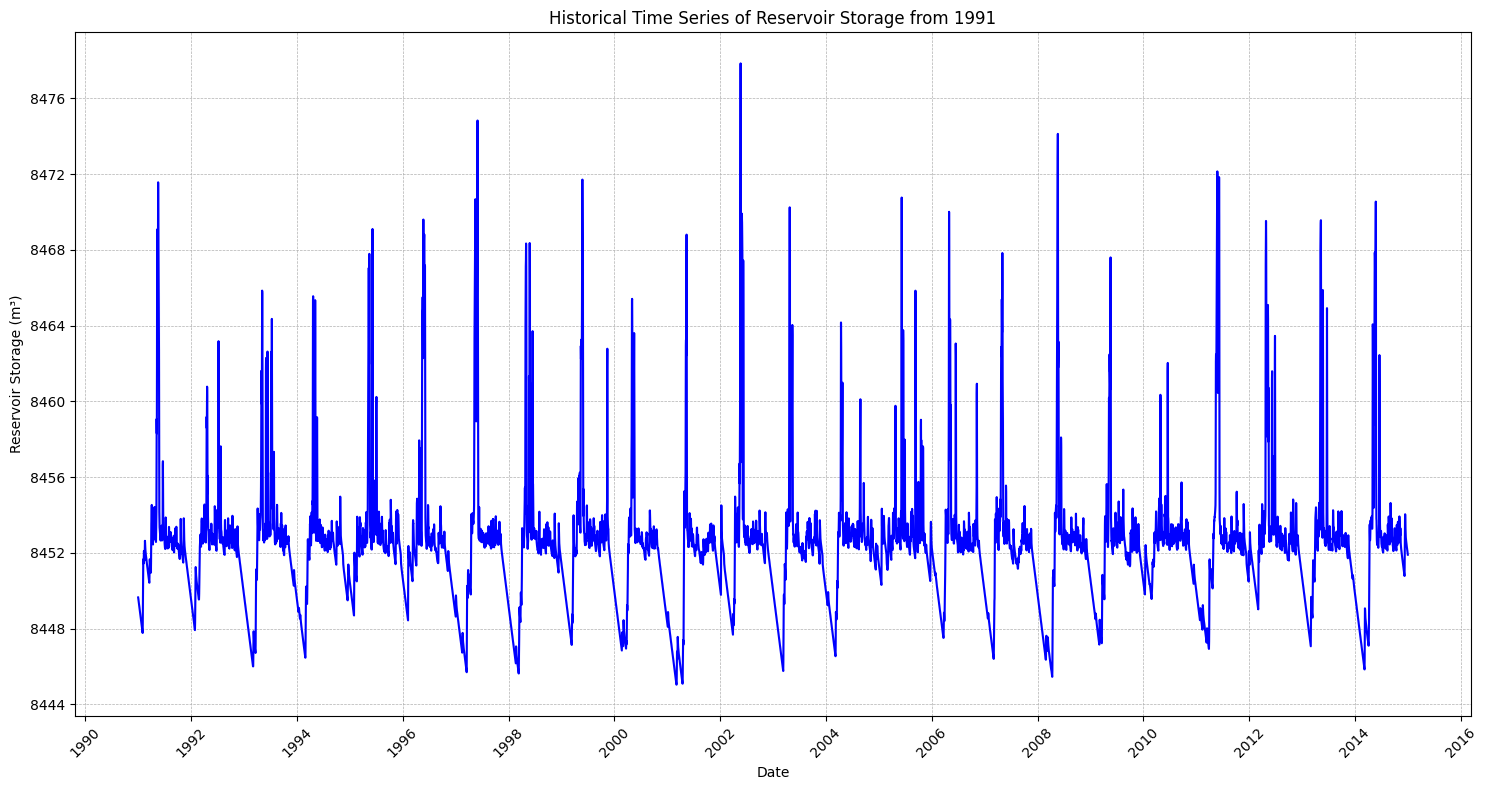

In [195]:
plot_timeseries_with_range_from_year(observed_dfs, start_year=1991, title_prefix="Historical")

## **Scenario 1:** SSP1-2.6 = *assumes reduced emissions*

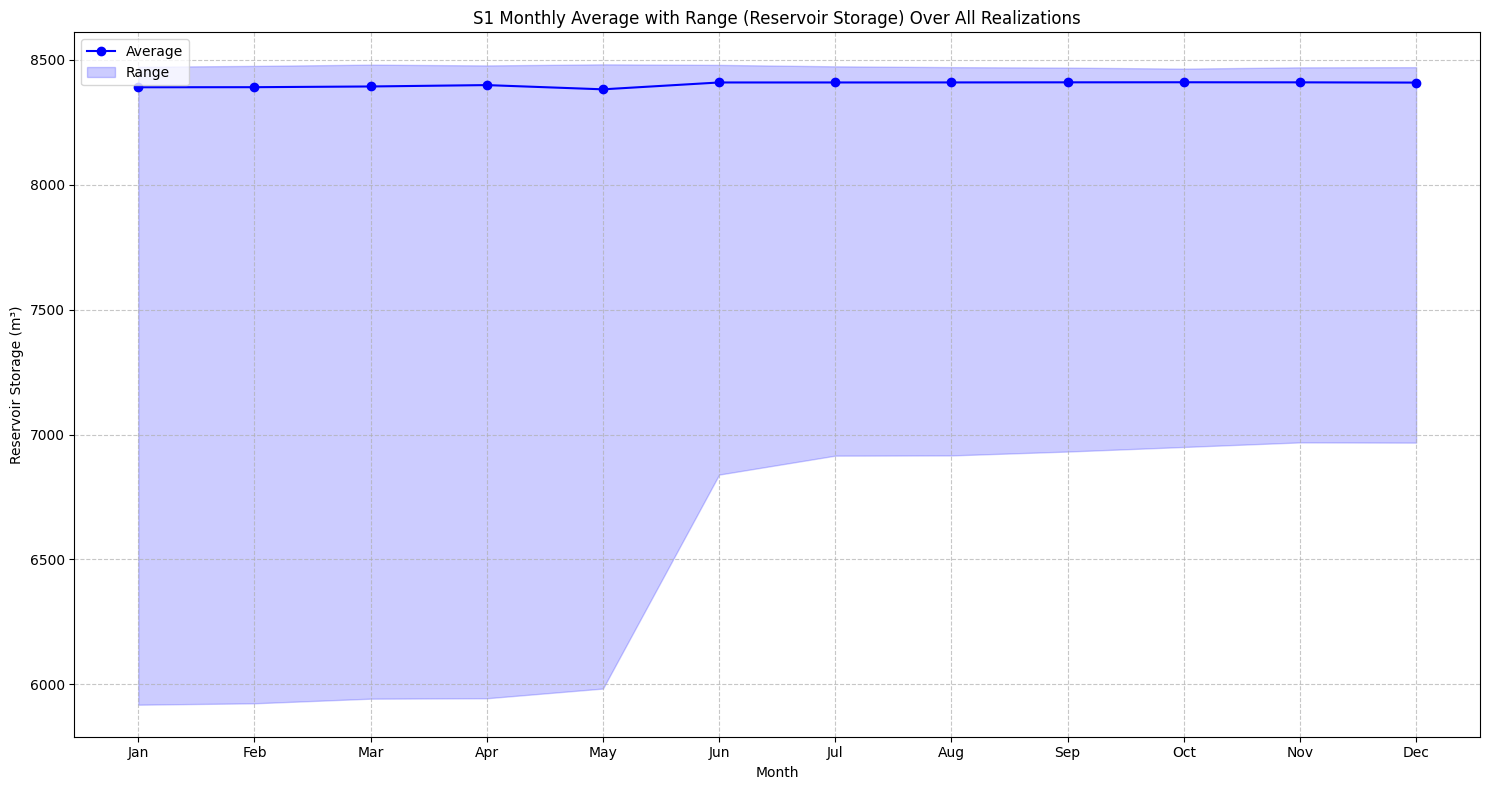

In [196]:
plot_monthly_average_with_range(s1_dfs, title_prefix="S1")

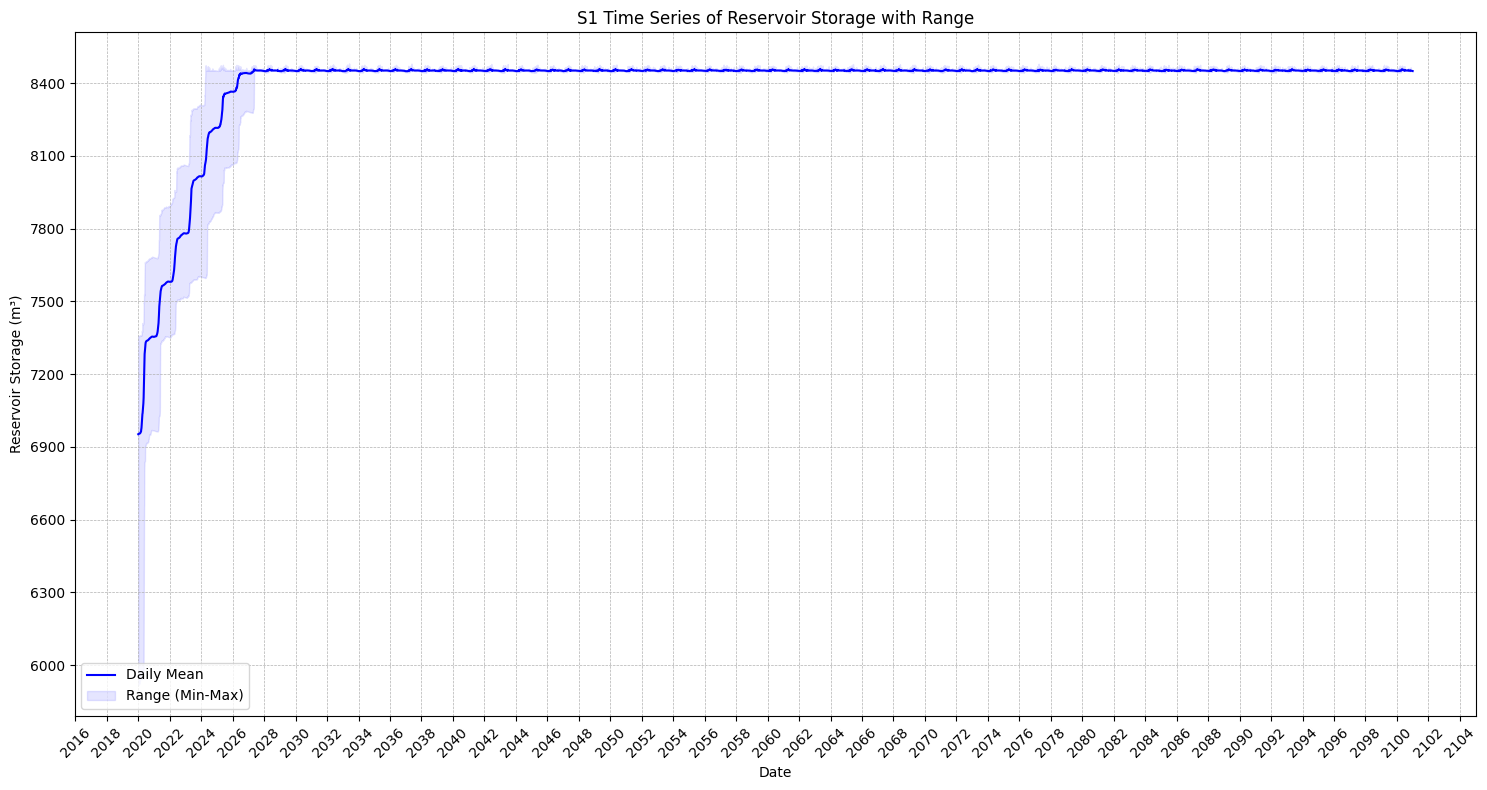

In [197]:
plot_timeseries_with_range(s1_dfs, title_prefix="S1")

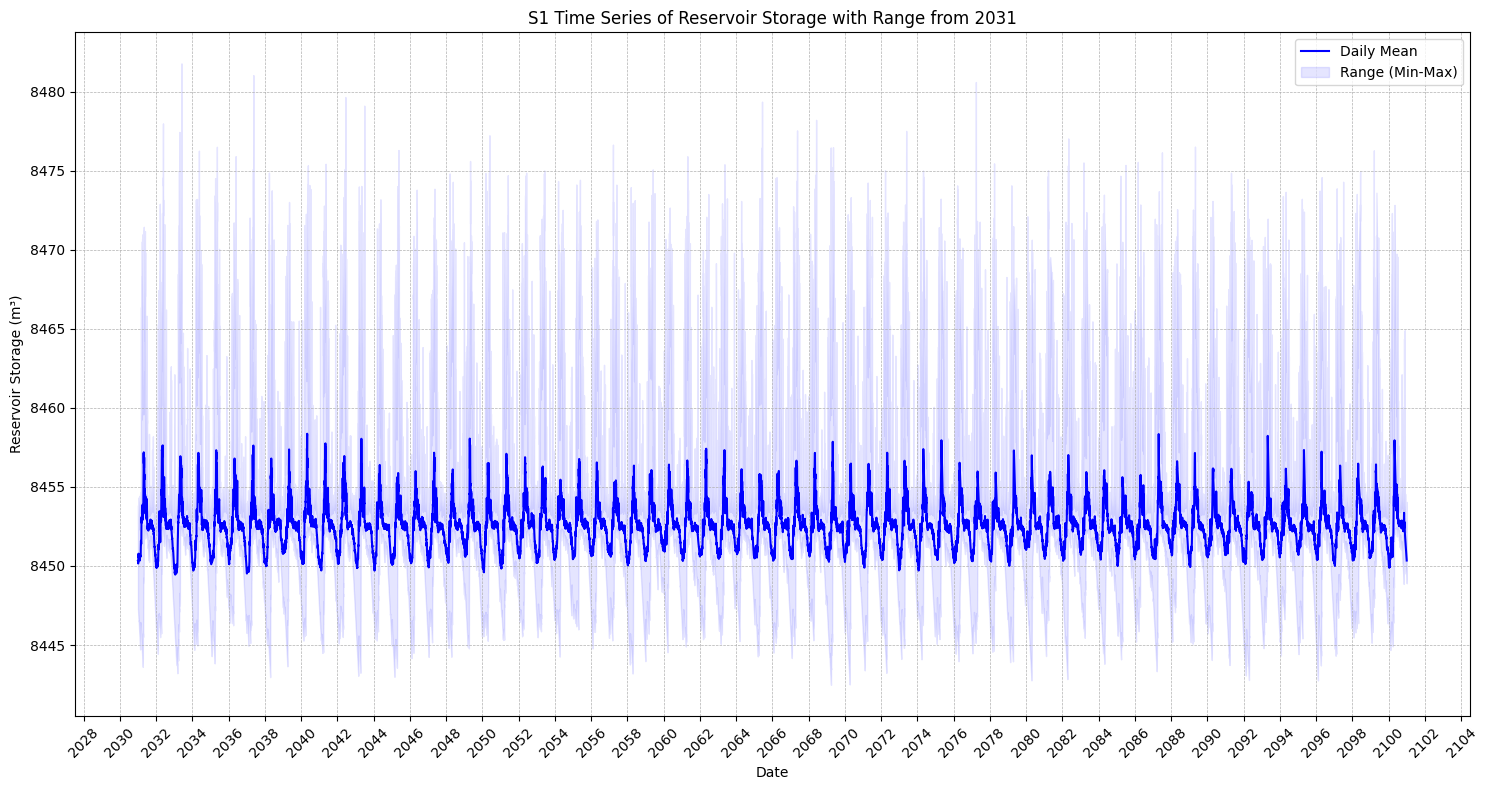

In [198]:
plot_timeseries_with_range_from_year(s1_dfs, start_year=2031, title_prefix="S1")

## **Scenario 2:** SSP2-4.5 = *assumes the same trend of emissions as historical*

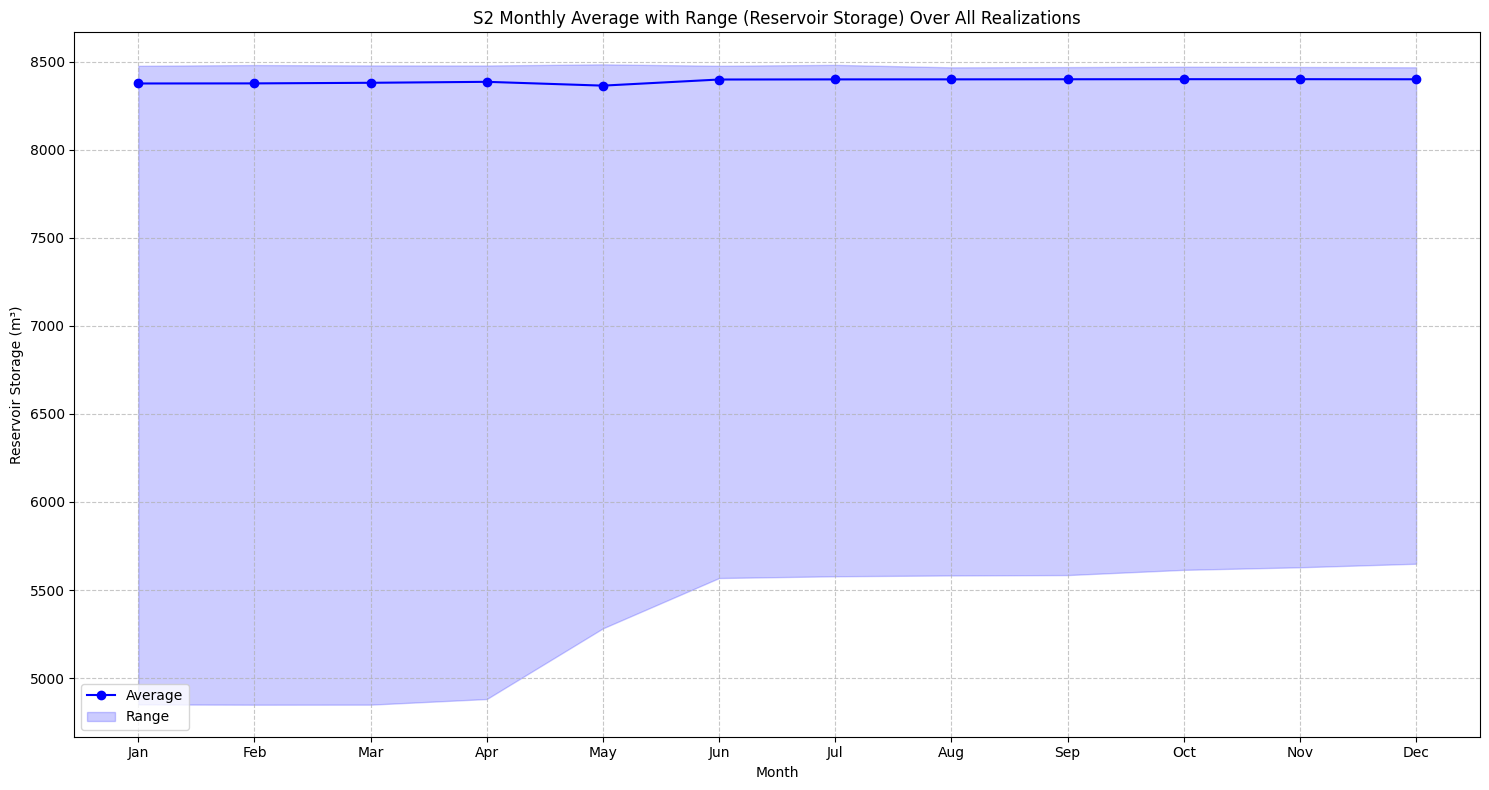

In [199]:
plot_monthly_average_with_range(s2_dfs, title_prefix="S2")

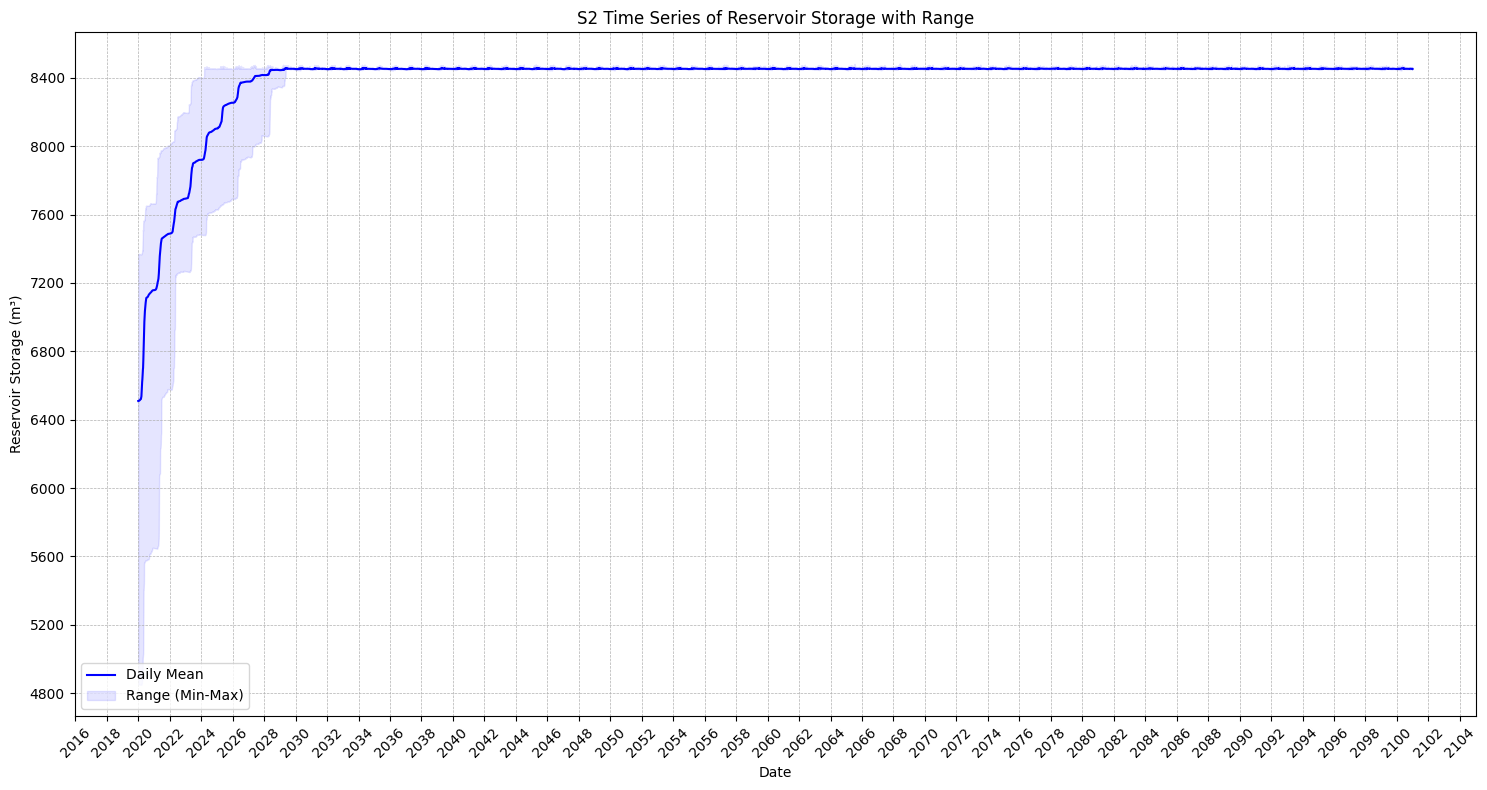

In [200]:
plot_timeseries_with_range(s2_dfs, title_prefix="S2")

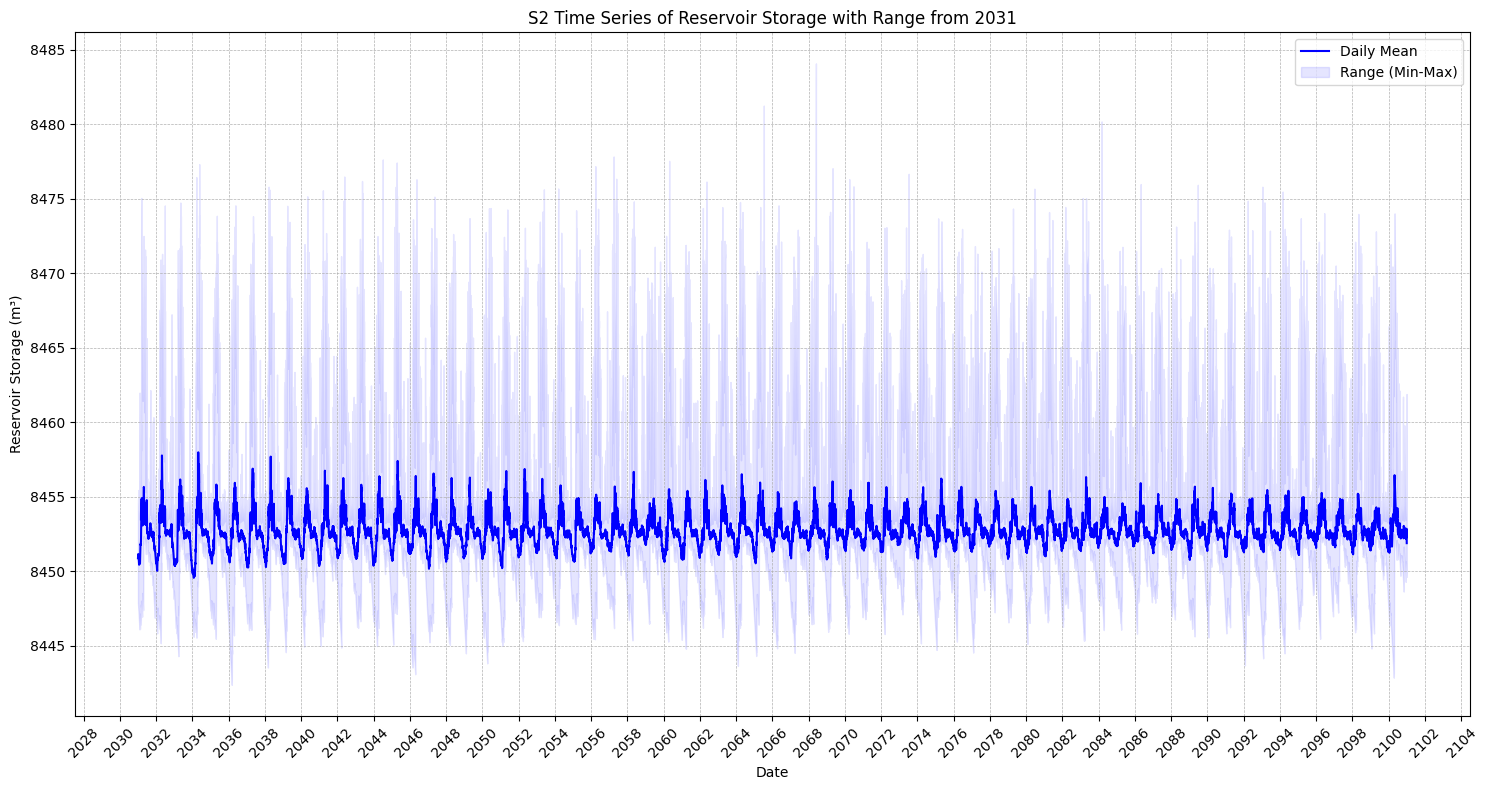

In [201]:
plot_timeseries_with_range_from_year(s2_dfs, start_year=2031, title_prefix="S2")

## **Scenario 3:** SSP3-7.0 = *medium to high emissions scenario*

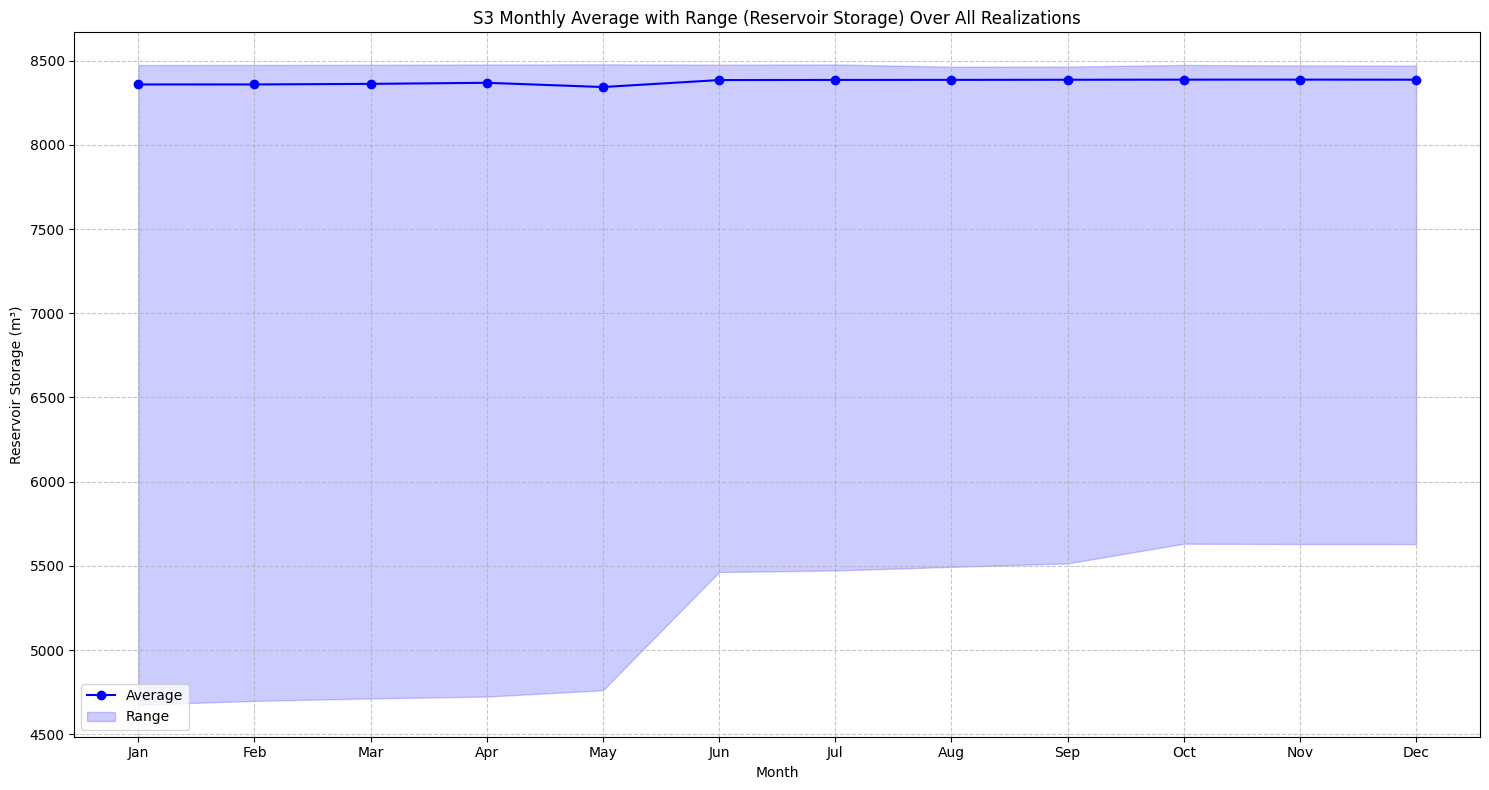

In [202]:
plot_monthly_average_with_range(s3_dfs, title_prefix="S3")

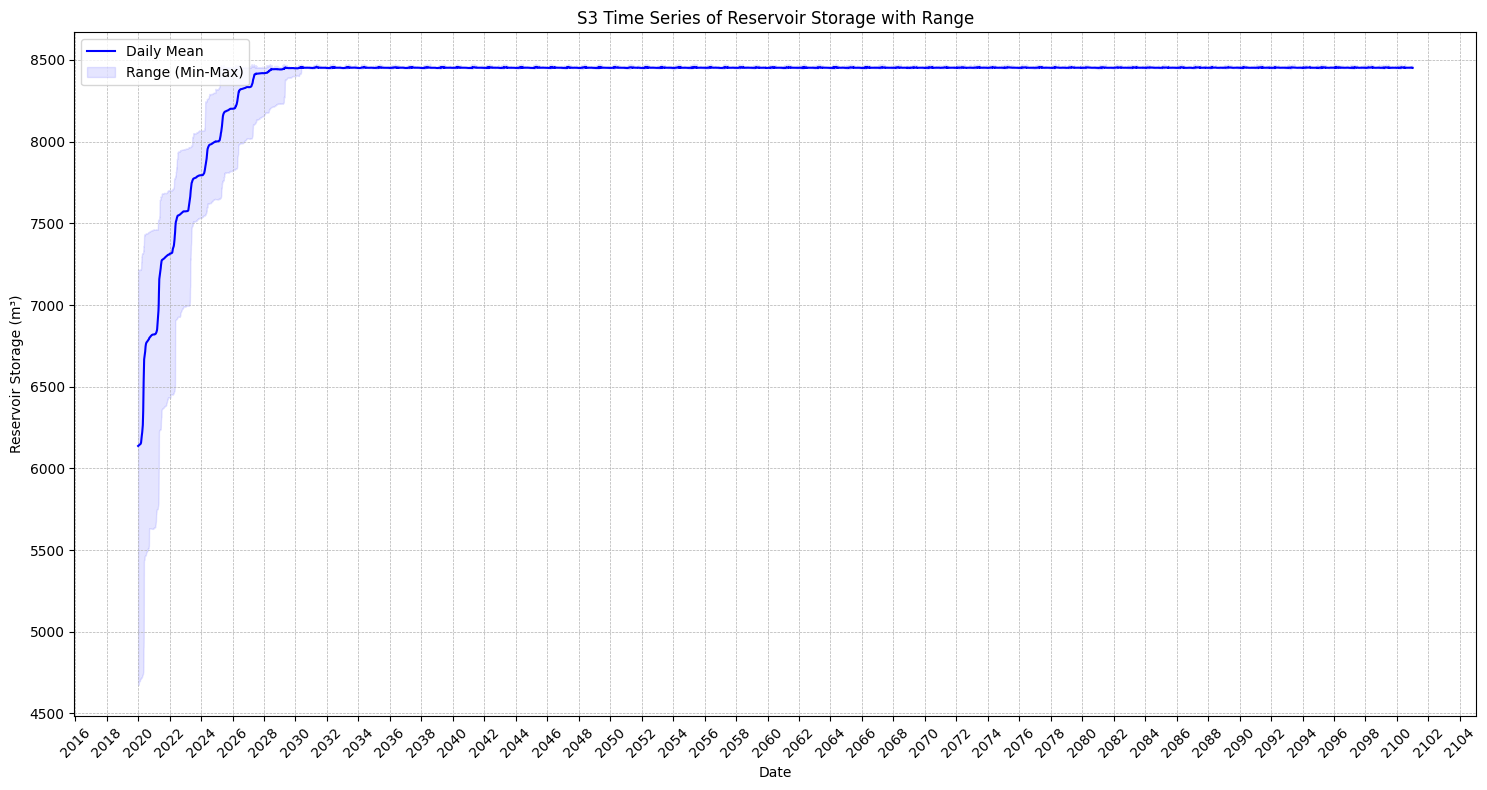

In [203]:
plot_timeseries_with_range(s3_dfs, title_prefix="S3")

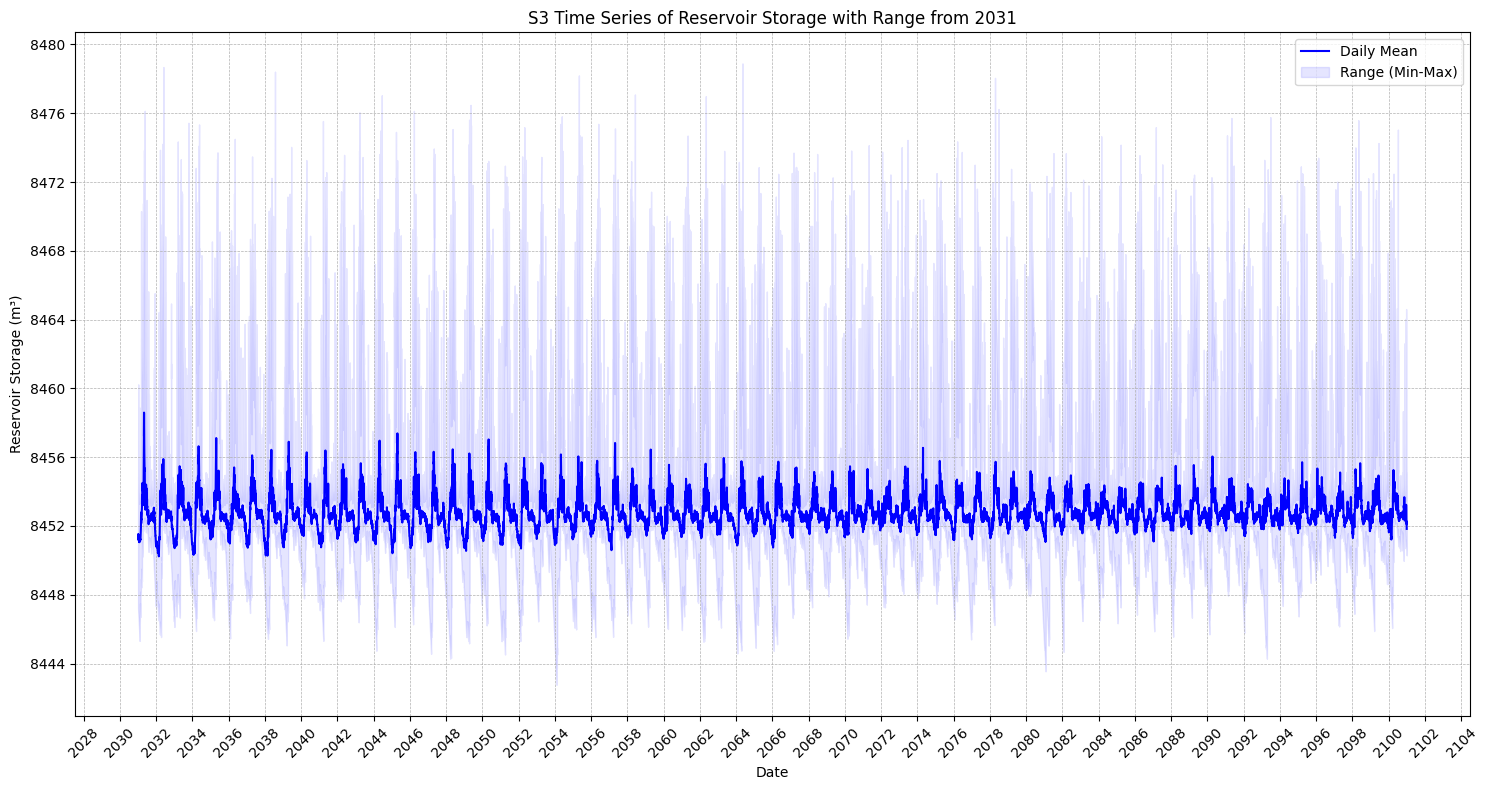

In [204]:
plot_timeseries_with_range_from_year(s3_dfs, start_year=2031, title_prefix="S3")

## **Scenario 4:** SSP5-8.5 = *optimal for economic development but with high emissions.*

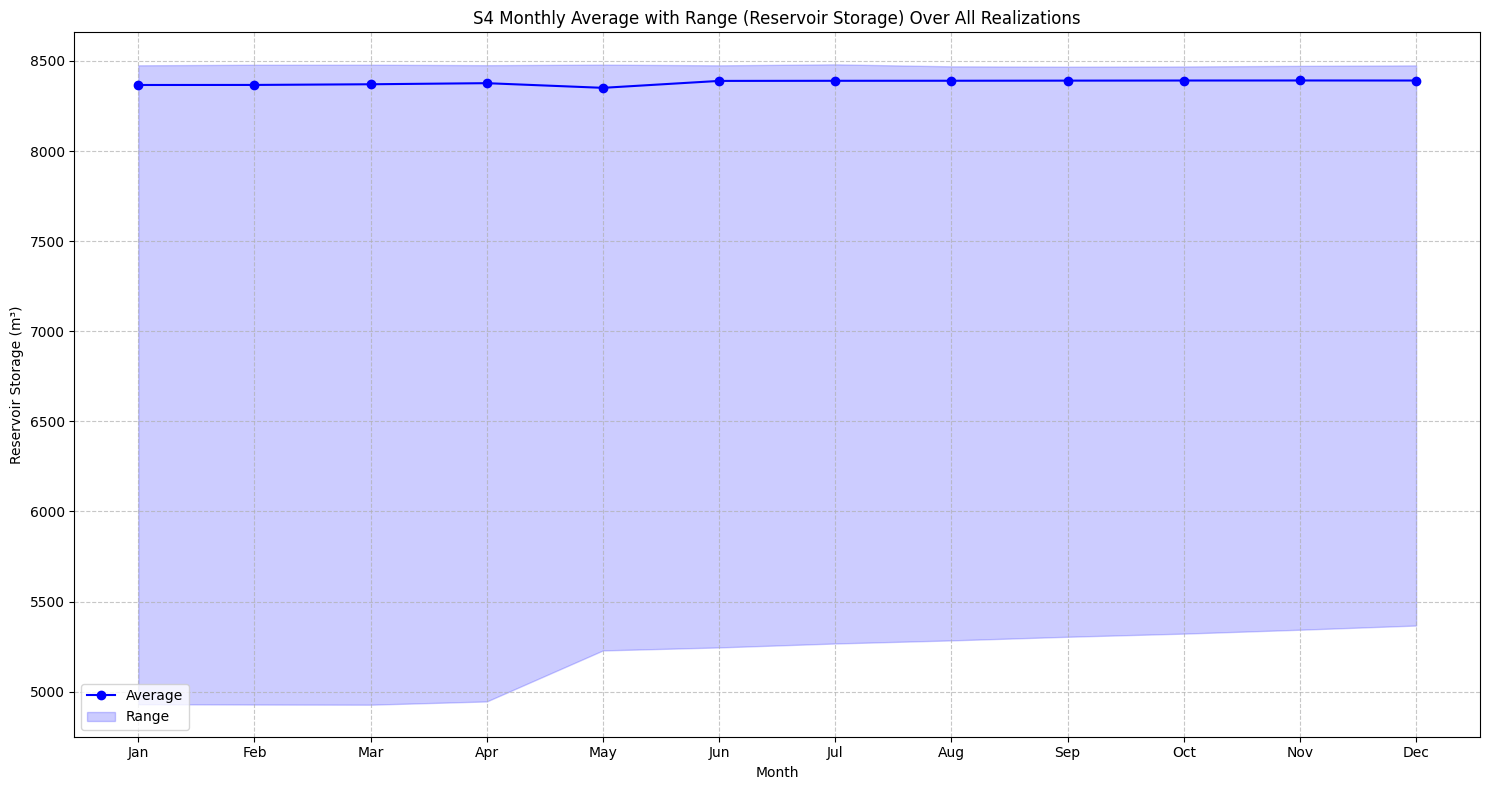

In [205]:
plot_monthly_average_with_range(s4_dfs, title_prefix="S4")

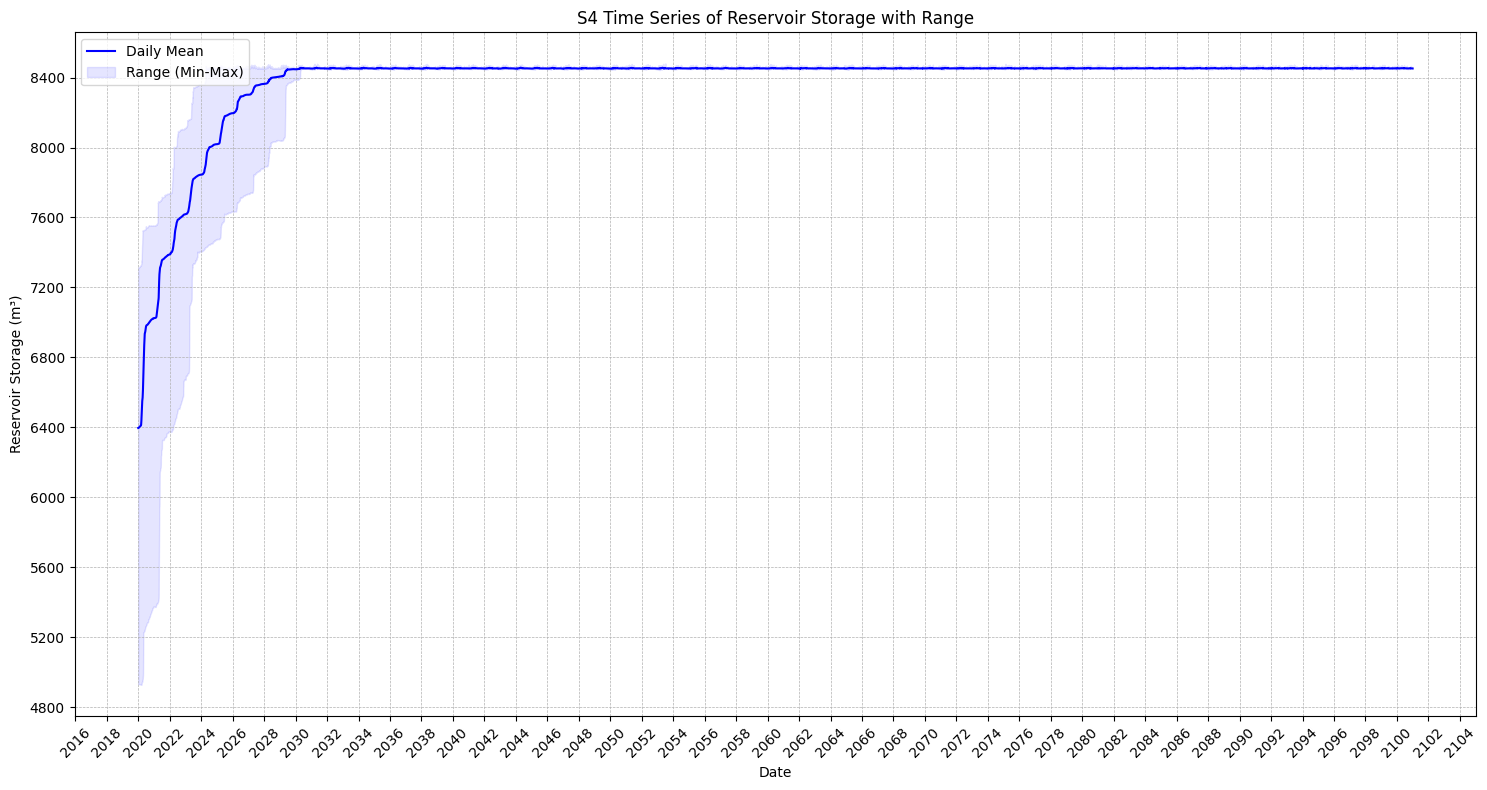

In [206]:
plot_timeseries_with_range(s4_dfs, title_prefix="S4")

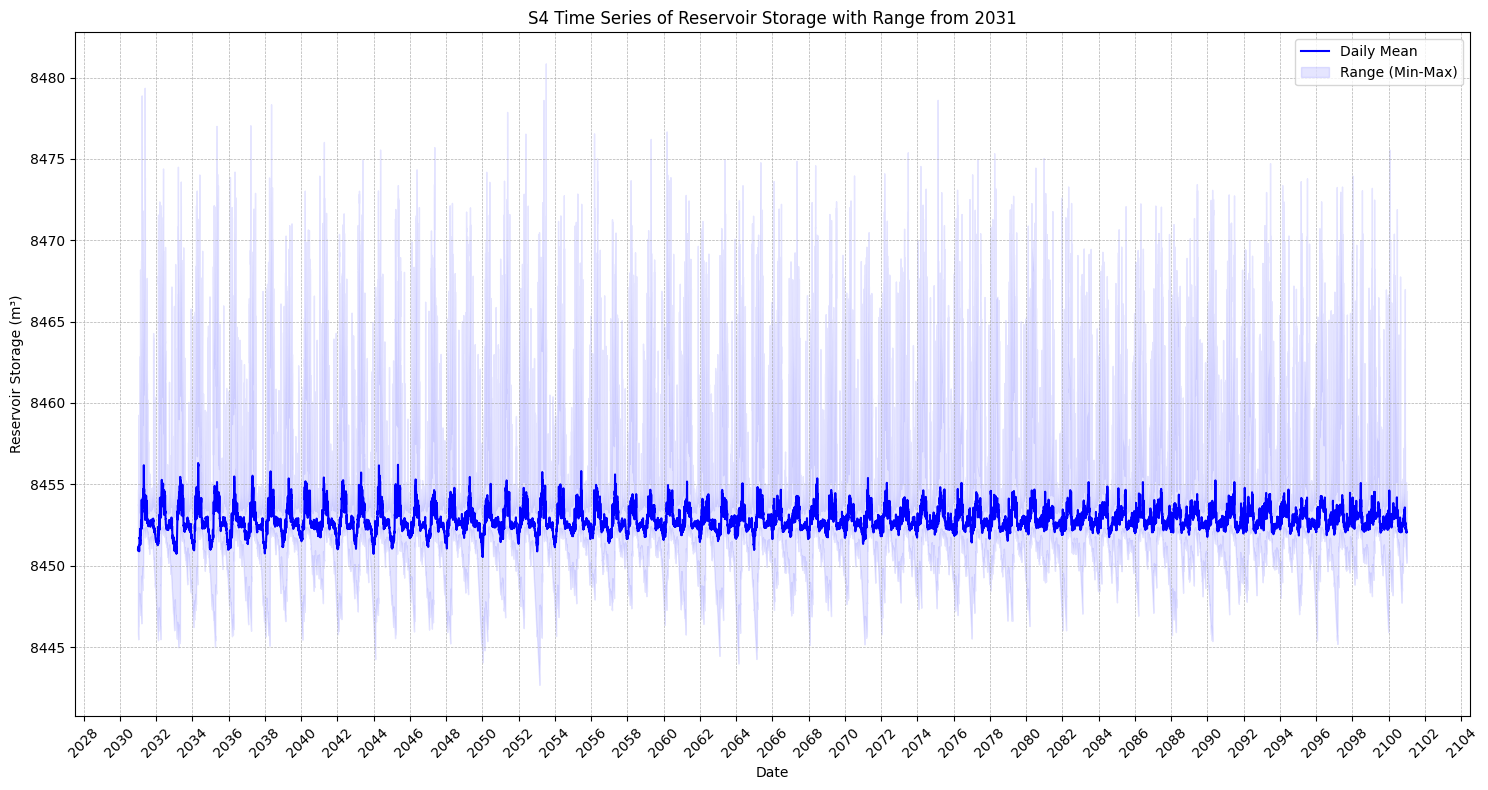

In [207]:
plot_timeseries_with_range_from_year(s4_dfs, start_year=2031, title_prefix="S4")

## Comparison

## All Realizations

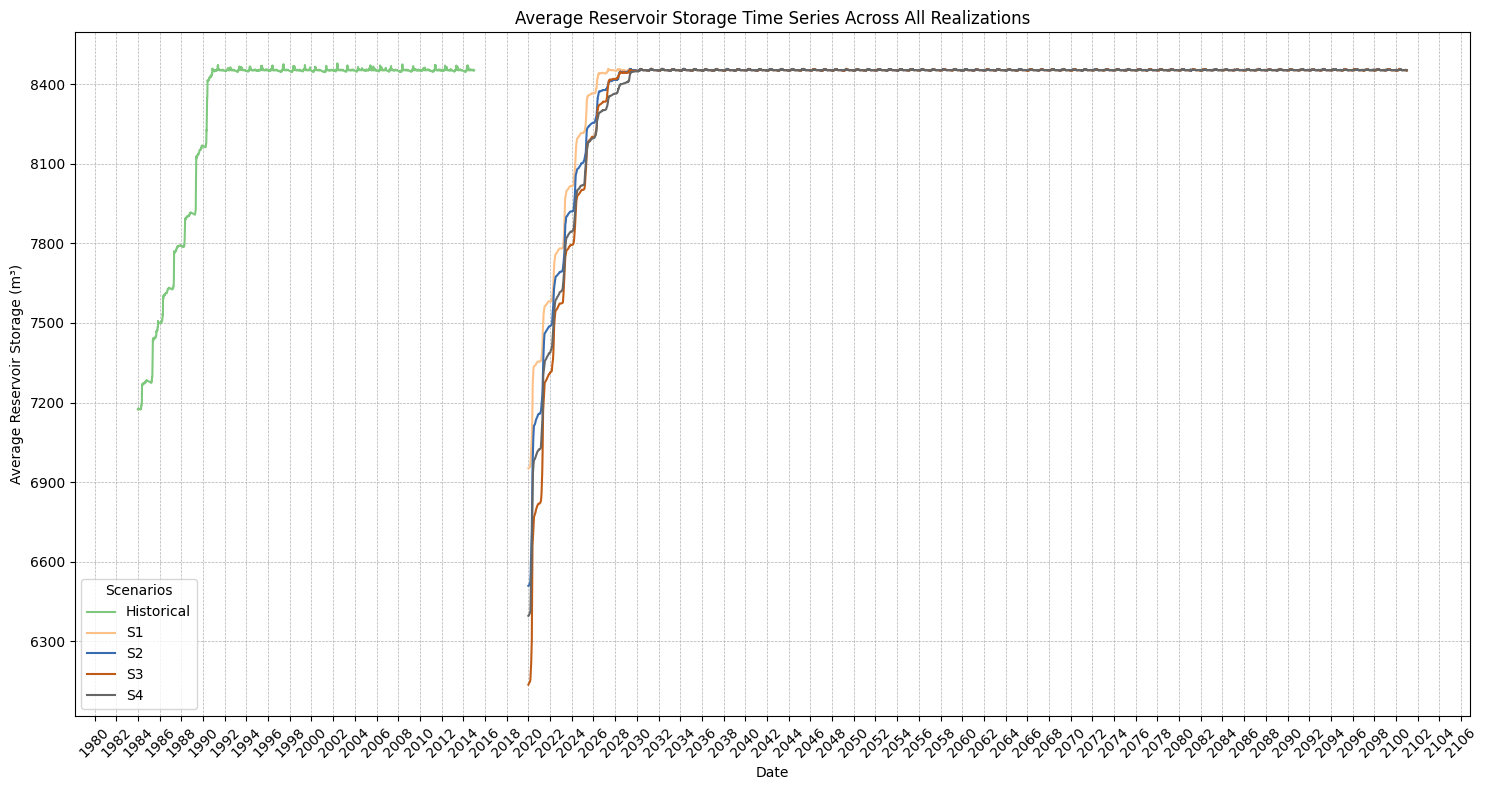

In [247]:
list_of_df_lists = [observed_dfs, s1_dfs, s2_dfs, s3_dfs, s4_dfs]
labels = ["Historical", "S1", "S2", "S3", "S4"]
plot_average_timeseries_for_lists(list_of_df_lists, labels, colorindex=[0, 2, 4, 6, 7])

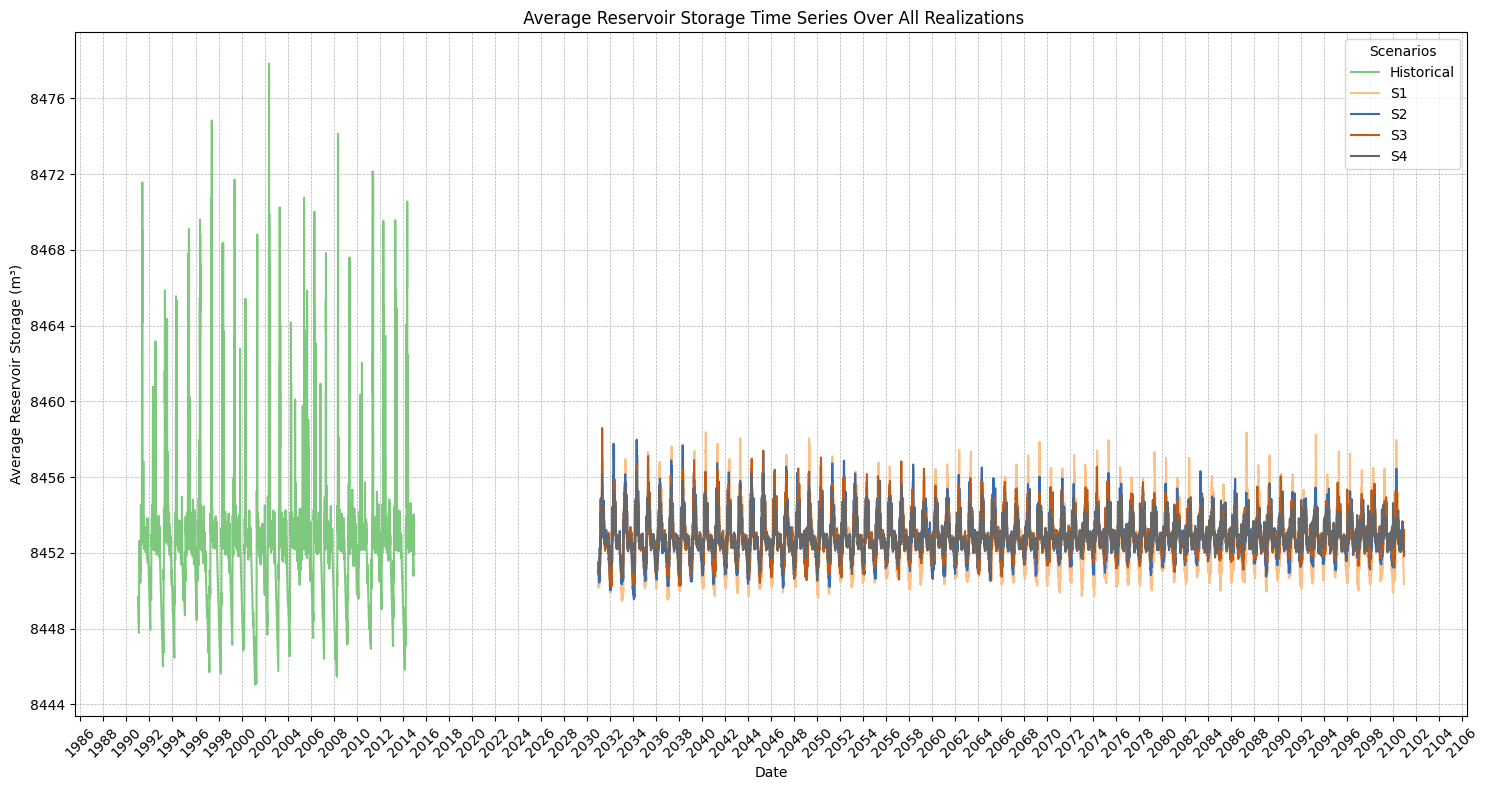

In [248]:
plot_average_timeseries_for_lists_with_diff_start_years(list_of_df_lists, labels, start_year_first=1991, start_year_others=2031, colorindex=[0, 2, 4, 6, 7])

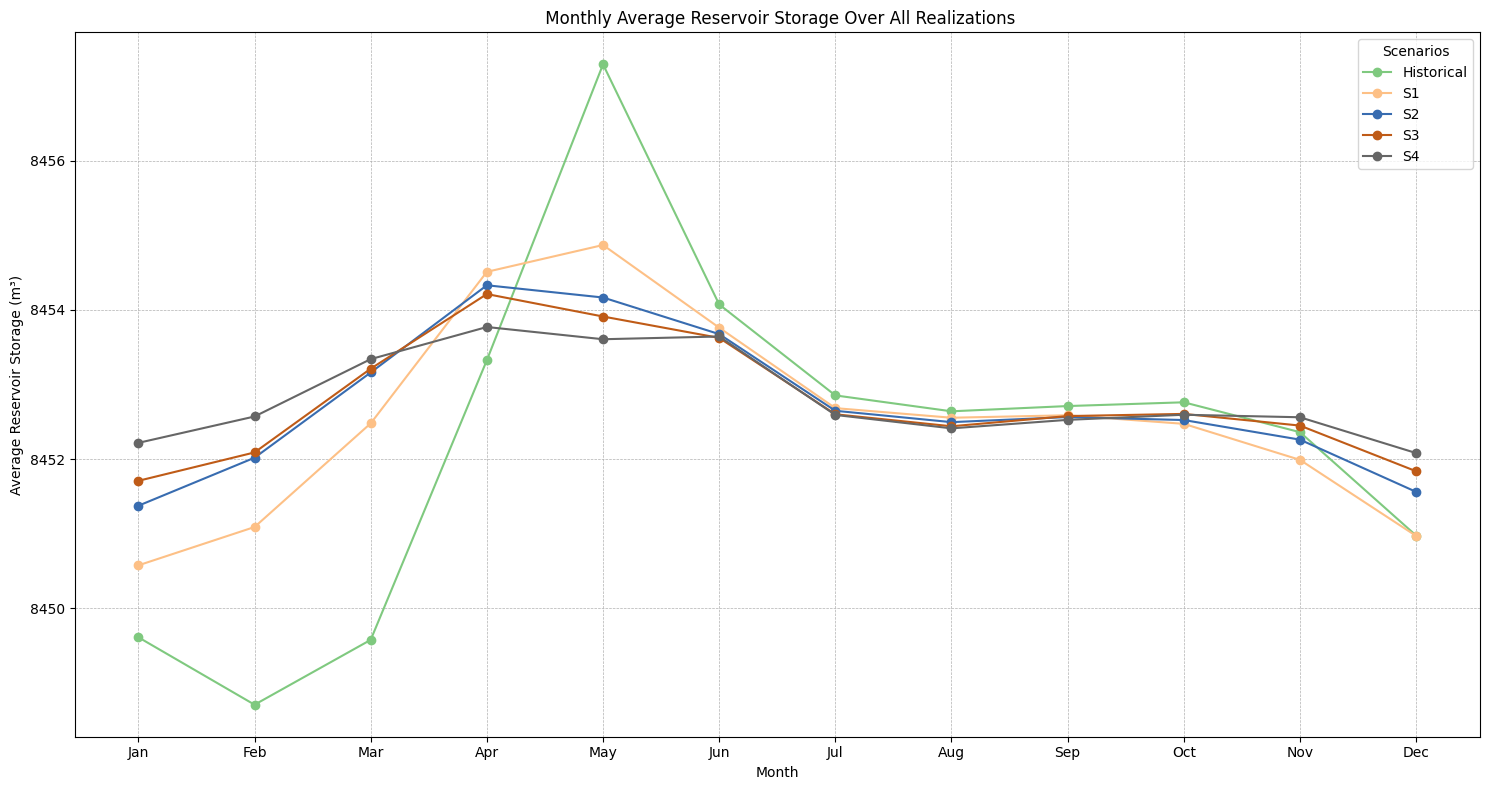

In [249]:
plot_monthly_average_for_lists_with_diff_start_years(list_of_df_lists, labels, start_year_first=1991, start_year_others=2031, colorindex=[0, 2, 4, 6, 7])

## Comparison of Future Scenarios

In [250]:
scenario_list_of_df_lists = [s1_dfs, s2_dfs, s3_dfs, s4_dfs] # removed observed data
labels_no_obs = ["S1", "S2", "S3", "S4"]

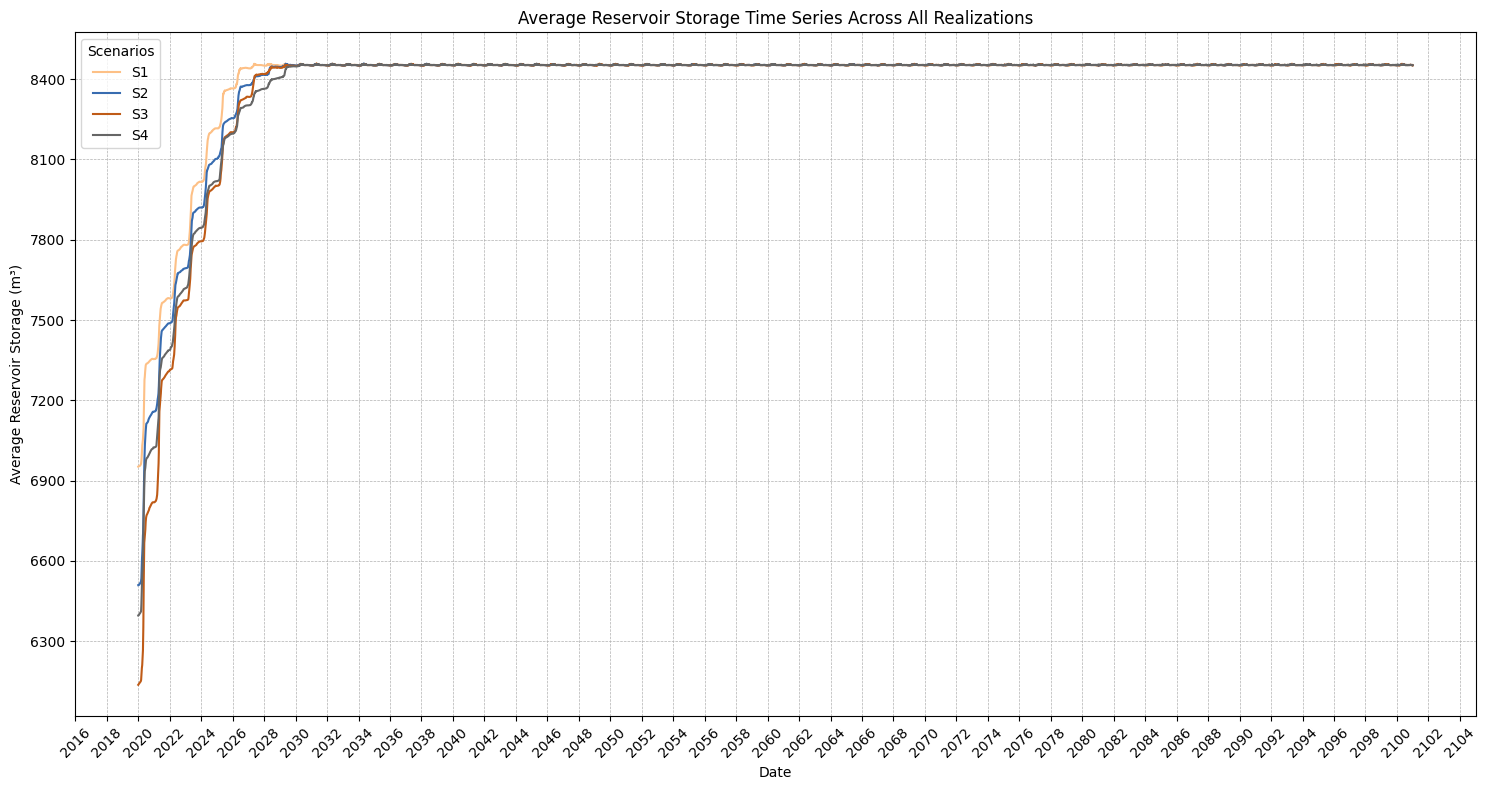

In [251]:
plot_average_timeseries_for_lists(scenario_list_of_df_lists, labels_no_obs, colorindex=[2, 4, 6, 7])

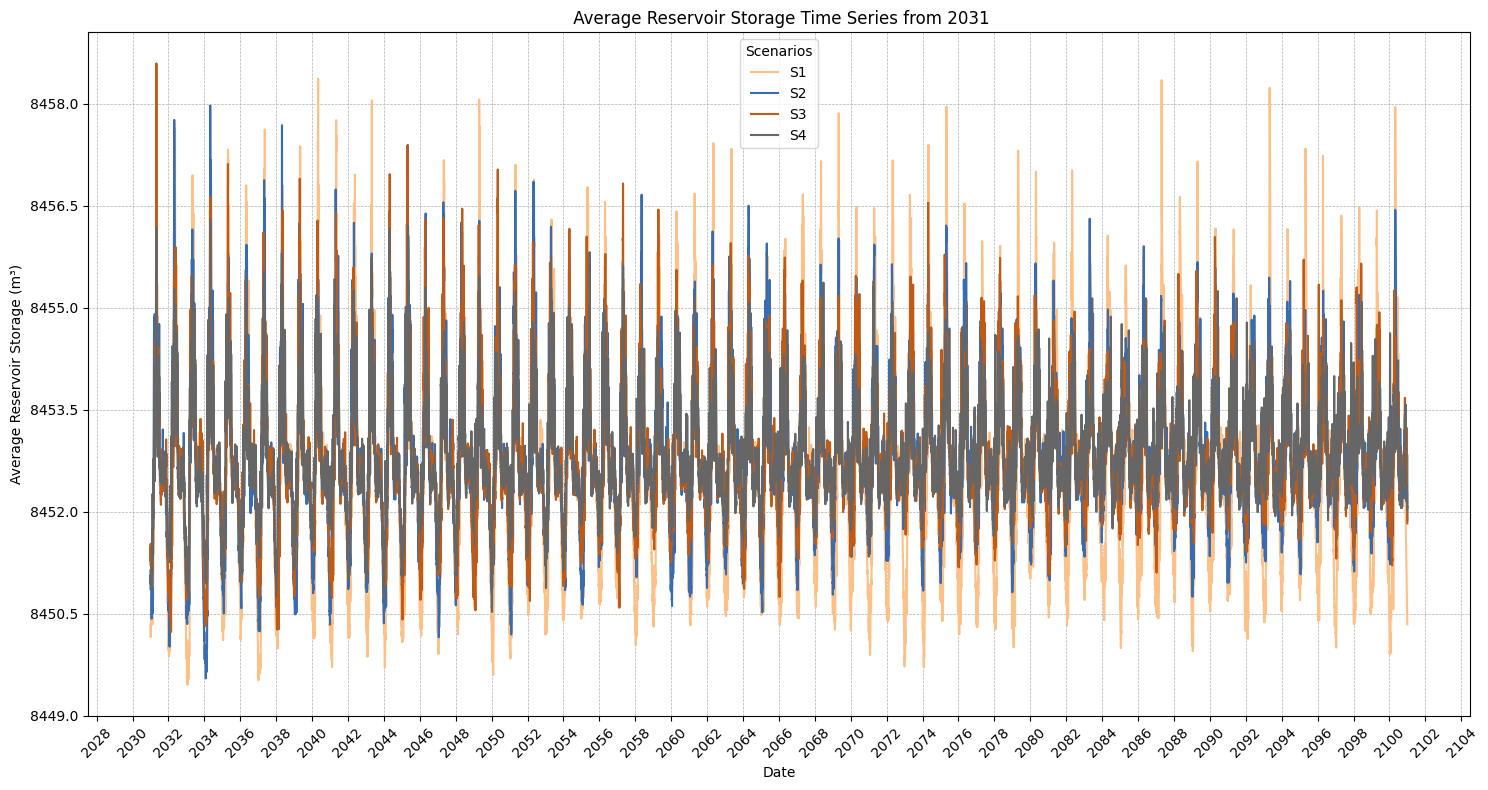

In [254]:
plot_average_timeseries_for_all_lists_starting_same_year(scenario_list_of_df_lists, labels_no_obs, start_year=2031, colorindex=[2, 4, 6, 7])

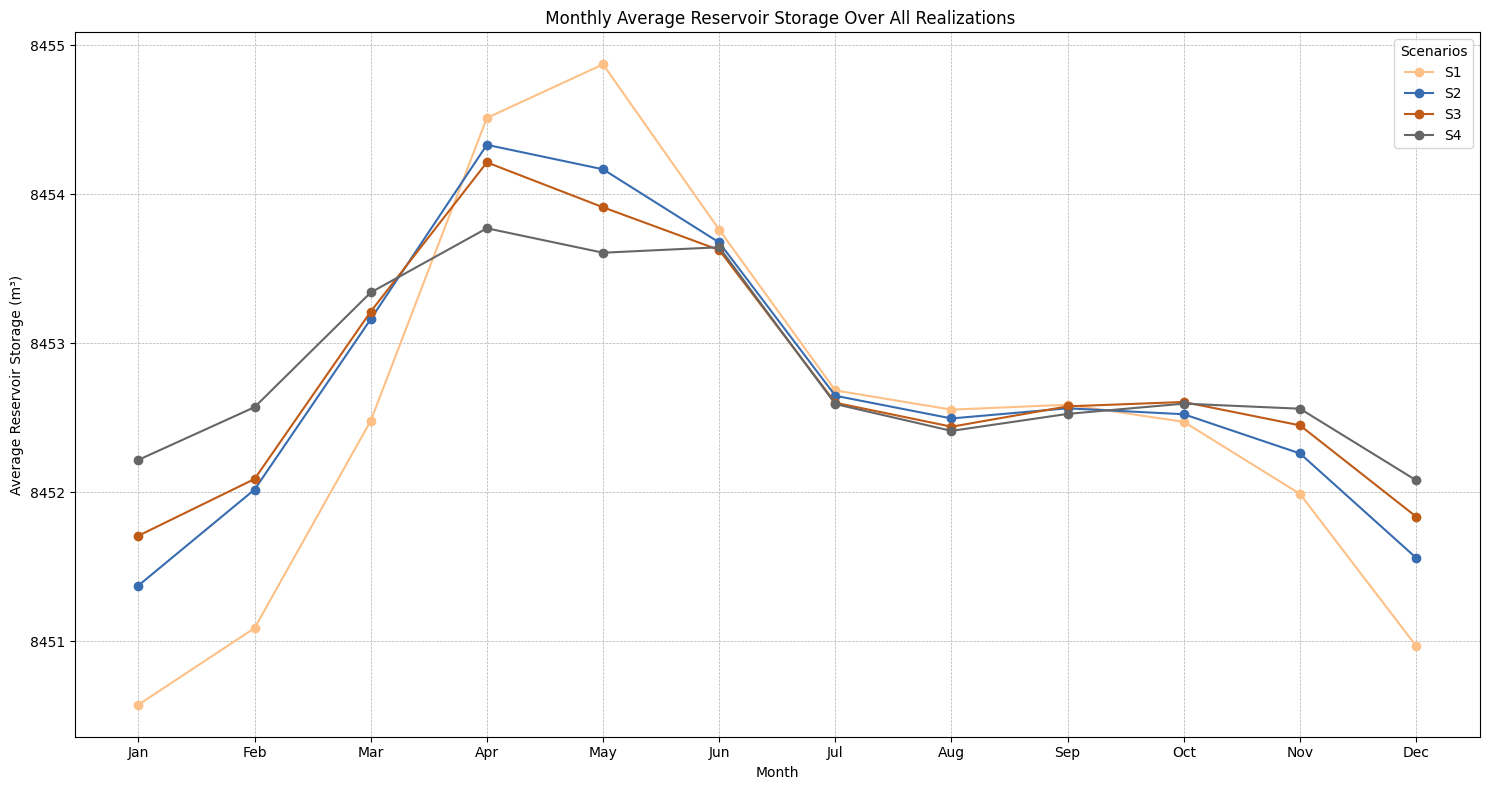

In [257]:
plot_monthly_average_for_lists_with_diff_start_years(scenario_list_of_df_lists, labels_no_obs, start_year_first=2031, start_year_others=2031, colorindex=[2, 4, 6, 7])